# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [3]:
# NB!: change this to the student id of one of your team members

assignment_seed = "5EB0100070"

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.4 MB/s eta 0:00:00


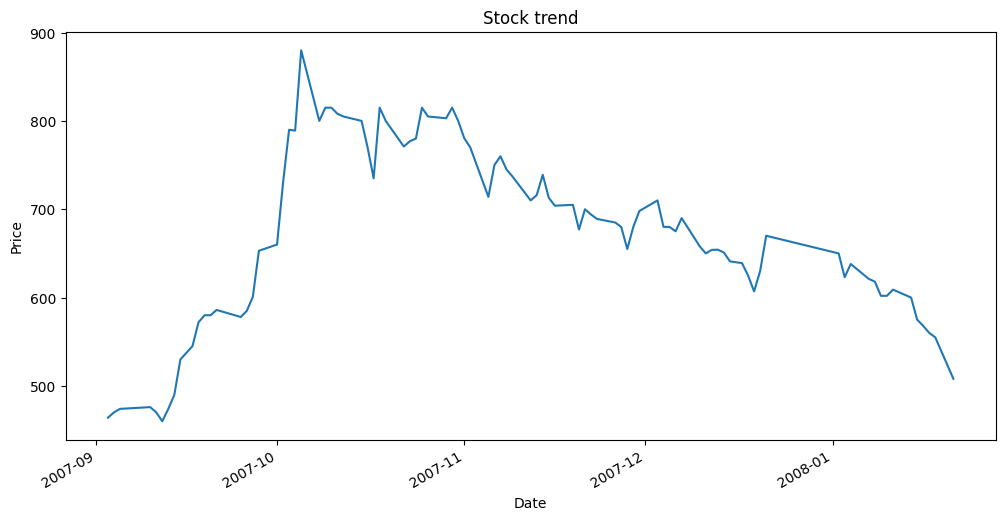

In [4]:
%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock trend")
plt.show()

Plot and Label the Stock

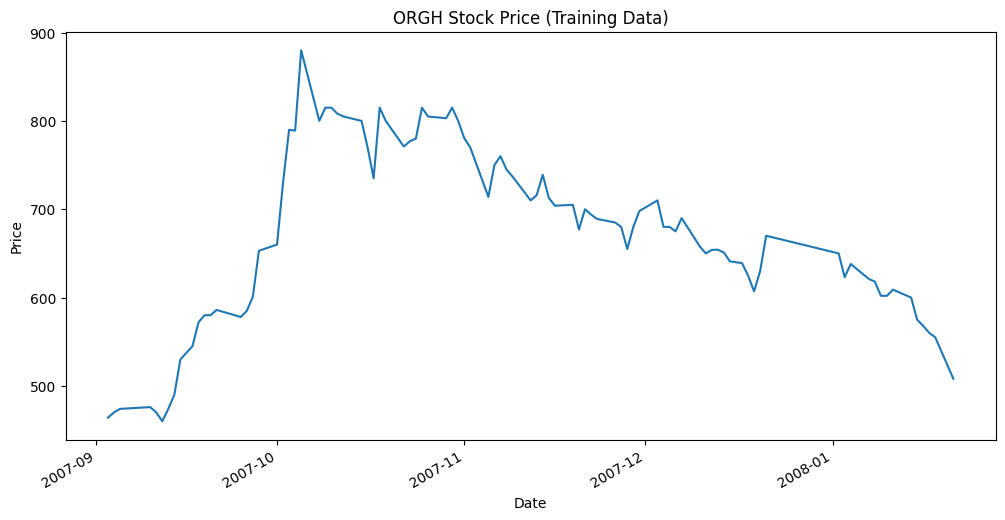

In [5]:
stock_name = dt.name

train.plot(figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{stock_name} Stock Price (Training Data)")
plt.show()


Stationarity: ADF & KPSS + ACF/PACF

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
adf_result = adfuller(train)
print("ADF Statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])

# KPSS test
kpss_result = kpss(train, regression='c', nlags="auto")
print("KPSS Statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])


ADF Statistic: -1.5736727496556153
ADF p-value: 0.49680362252469623
KPSS Statistic: 0.3373620216926494
KPSS p-value: 0.1


/tmp/ipython-input-3320765060.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train, regression='c', nlags="auto")


First difference

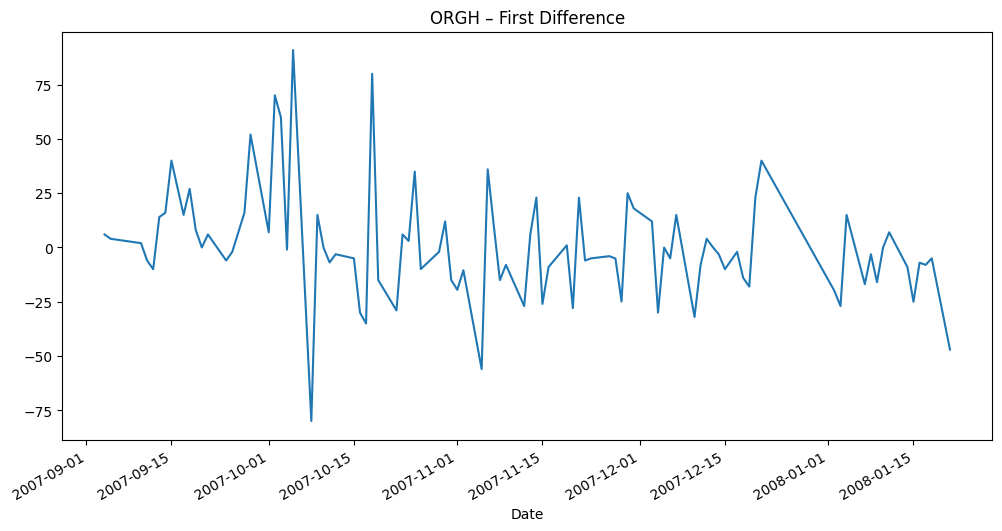

In [7]:
train_diff = train.diff().dropna()

train_diff.plot(figsize=(12,6))
plt.title(f"{stock_name} – First Difference")
plt.show()

ACF & PACF

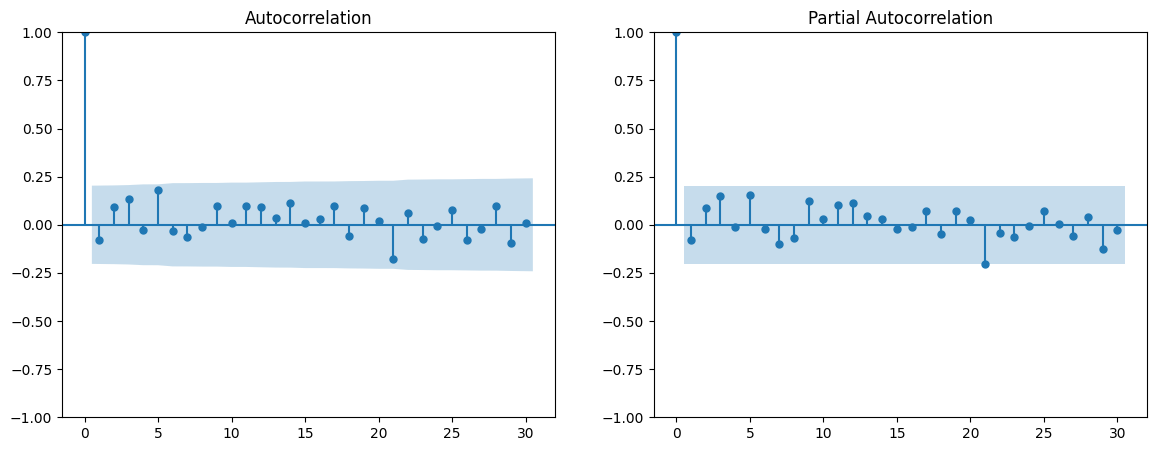

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(train_diff, ax=ax[0], lags=30)
plot_pacf(train_diff, ax=ax[1], lags=30, method='ywm')
plt.show()


Model Selection Using AIC / BIC

In [9]:
import itertools

p = range(0,4)
d = [1]
q = range(0,4)

results = []

for i in p:
    for j in q:
        try:
            model = ARIMA(train, order=(i,1,j))
            fit = model.fit()
            results.append([i,1,j, fit.aic, fit.bic])
        except:
            pass

results_df = pd.DataFrame(results, columns=["p","d","q","AIC","BIC"])
results_df.sort_values("AIC").head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,p,d,q,AIC,BIC
10,2,1,2,869.725441,882.388439
0,0,1,0,870.162206,872.694806
4,1,1,0,871.562814,876.628013
1,0,1,1,871.664921,876.730120
2,0,1,2,872.422863,880.020661


In [10]:
# Replace with actual numbers from results_df
p_star = 1
q_star = 1

best_model = ARIMA(train, order=(p_star, 1, q_star))
best_fit = best_model.fit()
print(best_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   ORGH   No. Observations:                   94
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -433.708
Date:                Sat, 10 Jan 2026   AIC                            873.416
Time:                        06:21:10   BIC                            881.013
Sample:                             0   HQIC                           876.483
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2893      1.254     -0.231      0.818      -2.747       2.169
ma.L1          0.2024      1.264      0.160      0.873      -2.275       2.680
sigma2       657.9157     70.627      9.315      0.0

Fit Final ARIMA Model

In [11]:
best_model = ARIMA(train, order=(p_star,1,q_star))
best_fit = best_model.fit()
print(best_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   ORGH   No. Observations:                   94
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -433.708
Date:                Sat, 10 Jan 2026   AIC                            873.416
Time:                        06:21:11   BIC                            881.013
Sample:                             0   HQIC                           876.483
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2893      1.254     -0.231      0.818      -2.747       2.169
ma.L1          0.2024      1.264      0.160      0.873      -2.275       2.680
sigma2       657.9157     70.627      9.315      0.0

Residual Diagnostics

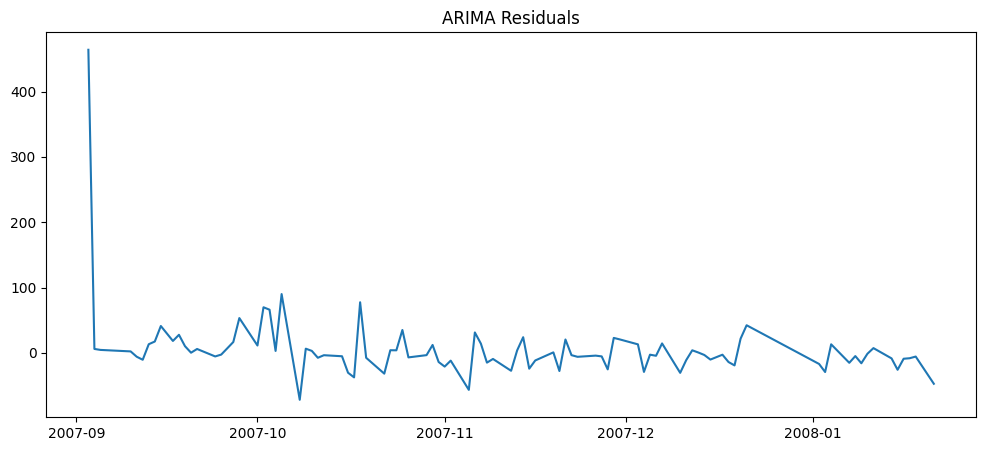

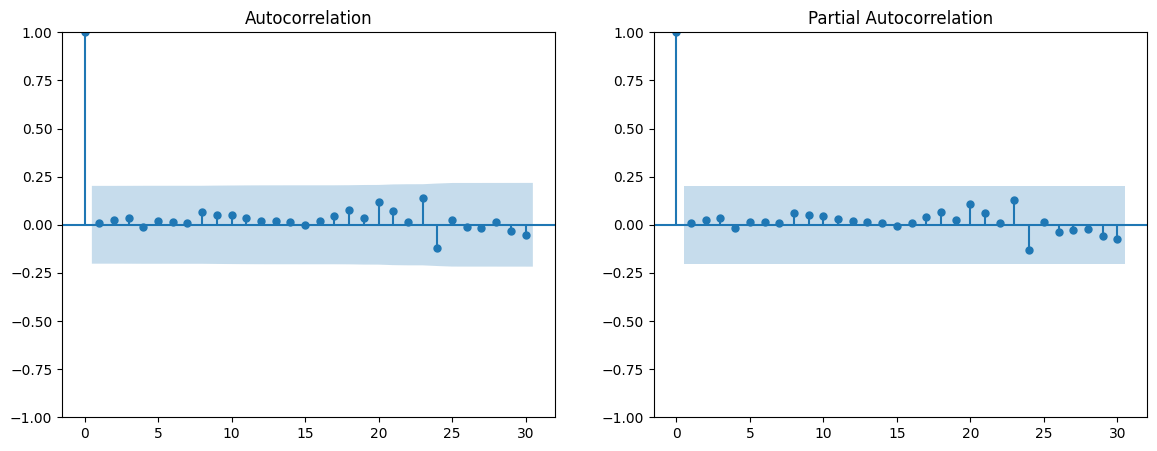

In [12]:
resid = best_fit.resid

# Residual plot
plt.figure(figsize=(12,5))
plt.plot(resid)
plt.title("ARIMA Residuals")
plt.show()

# ACF & PACF
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(resid, ax=ax[0], lags=30)
plot_pacf(resid, ax=ax[1], lags=30, method='ywm')
plt.show()


Ljung–Box test

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[10,20], return_df=True)
print(lb)


     lb_stat  lb_pvalue
10  1.242287   0.999539
20  4.365517   0.999905


Histogram & QQ-plot

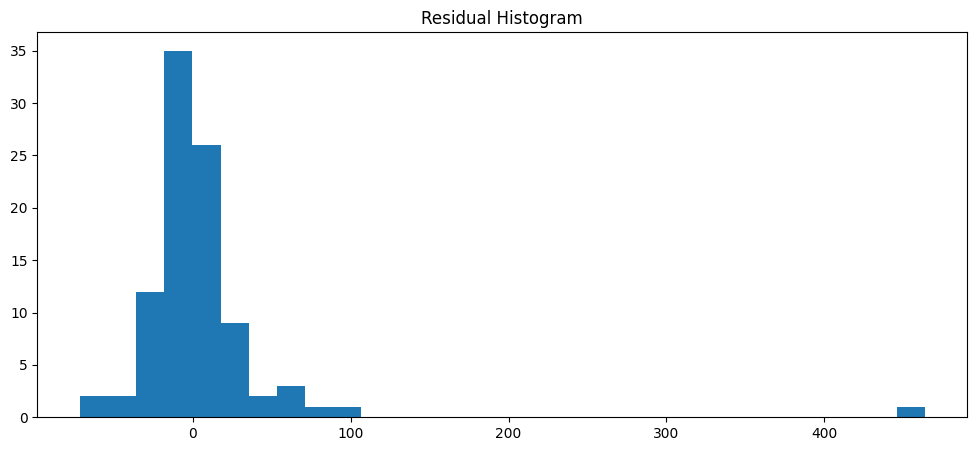

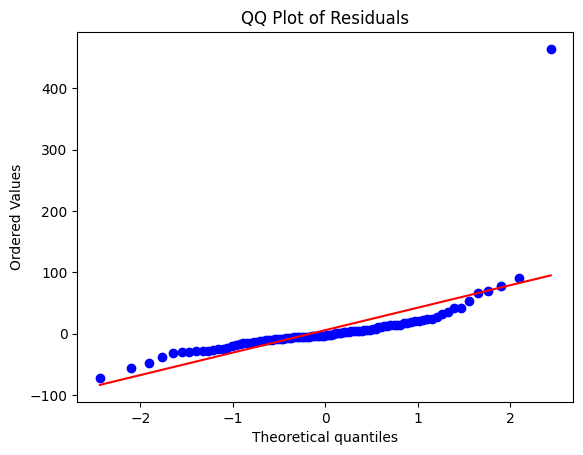

In [14]:
plt.figure(figsize=(12,5))
plt.hist(resid, bins=30)
plt.title("Residual Histogram")
plt.show()

stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()


Volatility Plot

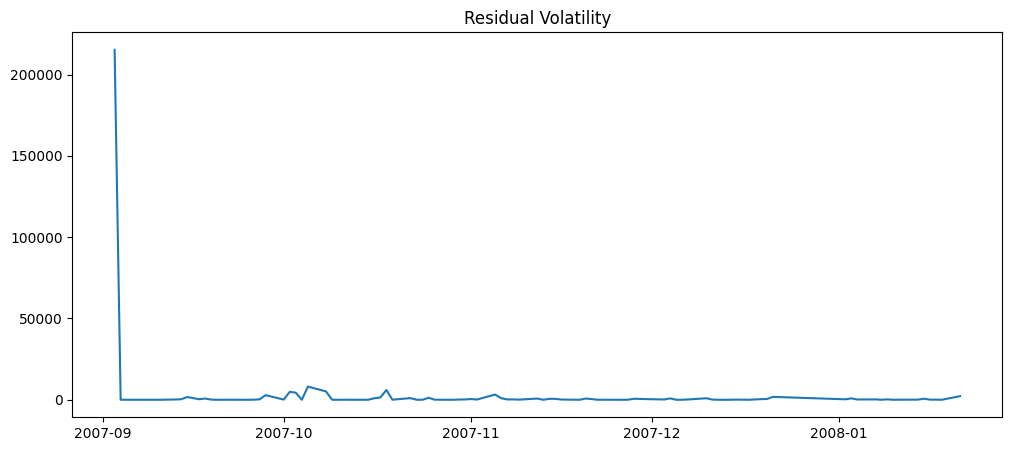

In [15]:
plt.figure(figsize=(12,5))
plt.plot(resid**2)
plt.title("Residual Volatility")
plt.show()


Fit ARCH / GARCH Models

In [16]:
# ARCH(1)
arch1 = arch_model(resid, vol="ARCH", p=1)
arch1_fit = arch1.fit()
print(arch1_fit.summary())

# GARCH(1,1)
garch11 = arch_model(resid, vol="GARCH", p=1, q=1)
garch11_fit = garch11.fit()
print(garch11_fit.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 454.2557075259029
Iteration:      2,   Func. Count:      9,   Neg. LLF: 481.8594111055697
Iteration:      3,   Func. Count:     14,   Neg. LLF: 450.2966700679986
Iteration:      4,   Func. Count:     18,   Neg. LLF: 450.2770881149347
Iteration:      5,   Func. Count:     22,   Neg. LLF: 450.27701168950176
Iteration:      6,   Func. Count:     26,   Neg. LLF: 450.27699403690394
Iteration:      7,   Func. Count:     30,   Neg. LLF: 450.2768779293621
Iteration:      8,   Func. Count:     34,   Neg. LLF: 450.2762163702782
Iteration:      9,   Func. Count:     38,   Neg. LLF: 450.2728328078273
Iteration:     10,   Func. Count:     42,   Neg. LLF: 450.2655216847777
Iteration:     11,   Func. Count:     46,   Neg. LLF: 450.25435730417576
Iteration:     12,   Func. Count:     50,   Neg. LLF: 450.23394454485265
Iteration:     13,   Func. Count:     54,   Neg. LLF: 450.21862375618105
Iteration:     14,   Func. Count:     58,   Neg. LLF: 450.2

Conditional Volatility

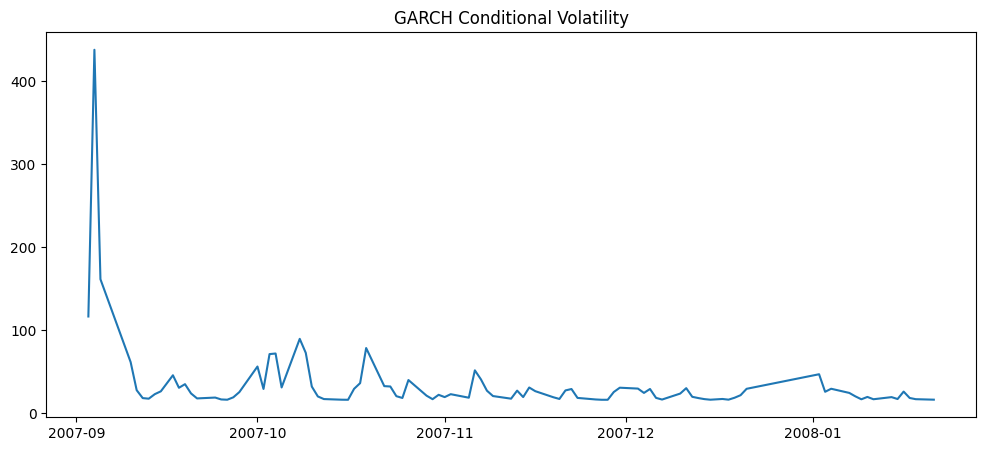

In [17]:
plt.figure(figsize=(12,5))
plt.plot(garch11_fit.conditional_volatility)
plt.title("GARCH Conditional Volatility")
plt.show()


Standardized Residuals

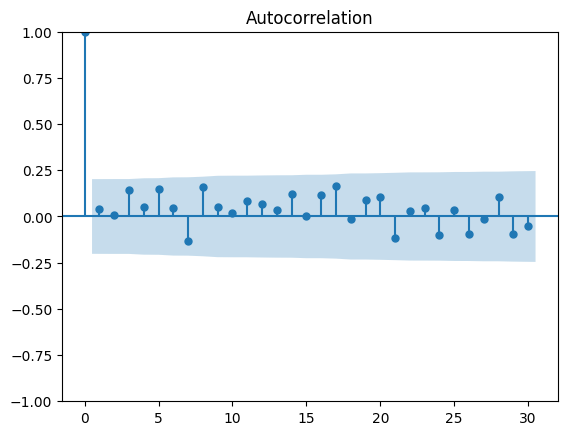

,lb_stat,lb_pvalue
10,9.902611,0.449079
20,20.004524,0.457647


In [18]:
std_resid = garch11_fit.std_resid

# ACF
plot_acf(std_resid, lags=30)
plt.show()

# Ljung-Box
acorr_ljungbox(std_resid, lags=[10,20], return_df=True)


Histogram & QQ-plot

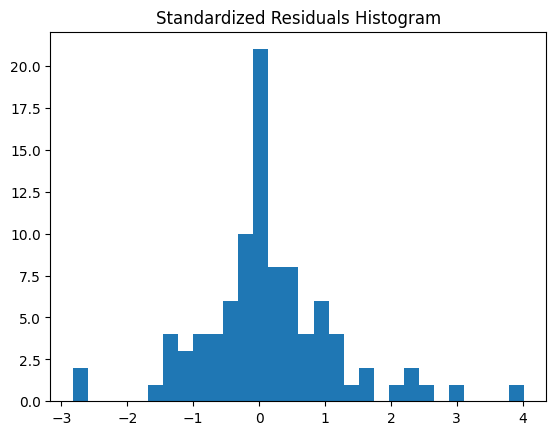

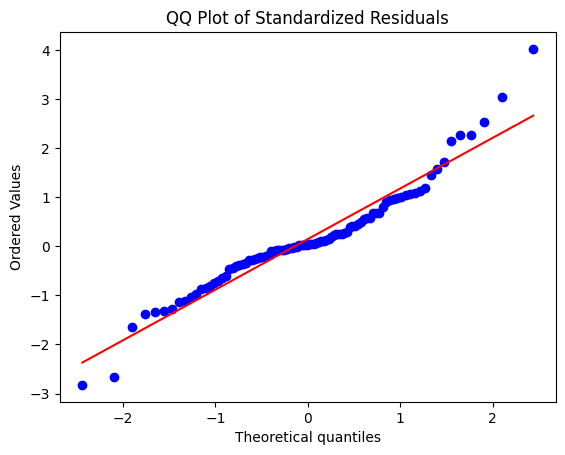

In [19]:
plt.hist(std_resid, bins=30)
plt.title("Standardized Residuals Histogram")
plt.show()

stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("QQ Plot of Standardized Residuals")
plt.show()


Test for Asymmetry (Leverage Effect)

In [20]:
gjr = arch_model(resid, vol="GARCH", p=1, o=1, q=1)
gjr_fit = gjr.fit()
print(gjr_fit.summary())


Iteration:      1,   Func. Count:      7,   Neg. LLF: 2627.4750180680862
Iteration:      2,   Func. Count:     14,   Neg. LLF: 462.6482422434923
Iteration:      3,   Func. Count:     21,   Neg. LLF: 476.49916599193216
Iteration:      4,   Func. Count:     28,   Neg. LLF: 455.1476638658045
Iteration:      5,   Func. Count:     35,   Neg. LLF: 505.254426443686
Iteration:      6,   Func. Count:     42,   Neg. LLF: 452.9112120658145
Iteration:      7,   Func. Count:     48,   Neg. LLF: 452.8595889650507
Iteration:      8,   Func. Count:     54,   Neg. LLF: 452.8451337290906
Iteration:      9,   Func. Count:     60,   Neg. LLF: 452.7781217047934
Iteration:     10,   Func. Count:     66,   Neg. LLF: 452.630179921322
Iteration:     11,   Func. Count:     72,   Neg. LLF: 452.23522652424583
Iteration:     12,   Func. Count:     78,   Neg. LLF: 451.1087283891272
Iteration:     13,   Func. Count:     84,   Neg. LLF: 463.58314288402227
Iteration:     14,   Func. Count:     91,   Neg. LLF: 462.0684

Forecasting

In [21]:

forecast_arima = best_fit.forecast(steps=len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
train_diff = train.diff().dropna()
arma = ARIMA(train_diff, order=(p_star,0,q_star)).fit()
forecast_diff = arma.forecast(steps=len(test))

forecast_manual = train.iloc[-1] + forecast_diff.cumsum()
forecast_manual.isna().sum()
forecast_manual = forecast_manual.dropna()
forecast_manual.index = test.index[:len(forecast_manual)]

forecast_arima = best_fit.forecast(steps=len(test))
forecast_arima.index = test.index[:len(forecast_arima)]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Plot Forecasts vs Actual

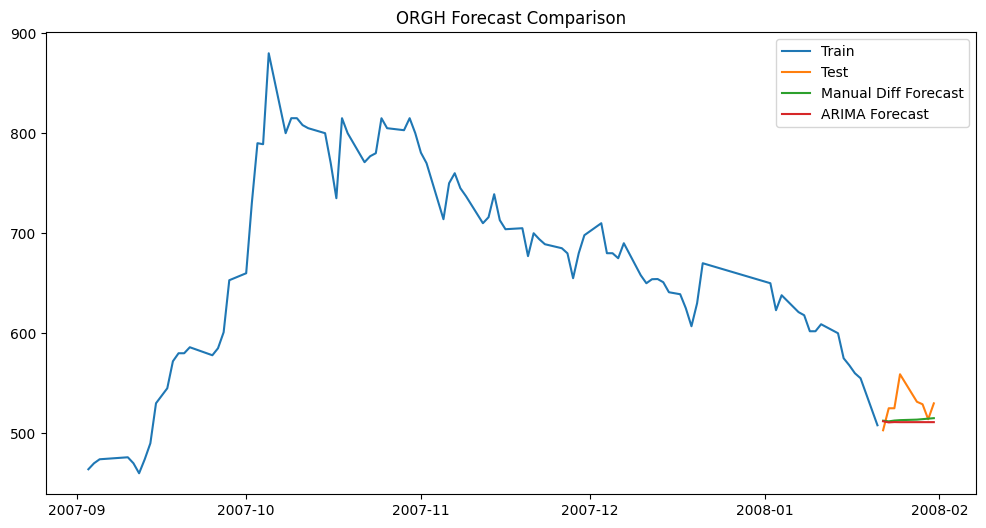

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast_manual, label="Manual Diff Forecast")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title(f"{stock_name} Forecast Comparison")
plt.show()


RMSE

In [24]:
forecast_manual.index = test.index[:len(forecast_manual)]
forecast_arima.index = test.index[:len(forecast_arima)]

rmse_df = pd.concat([test, forecast_manual, forecast_arima], axis=1)
rmse_df.columns = ["test", "forecast_manual", "forecast_arima"]

rmse_df = rmse_df.dropna()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_manual = np.sqrt(mean_squared_error(rmse_df["test"], rmse_df["forecast_manual"]))
rmse_arima = np.sqrt(mean_squared_error(rmse_df["test"], rmse_df["forecast_arima"]))

print("RMSE Manual Differencing:", rmse_manual)
print("RMSE Integrated ARIMA:", rmse_arima)



RMSE Manual Differencing: 20.246334427553148
RMSE Integrated ARIMA: 21.971018152910855
